In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.11.2
pandas==1.3.2
numpy==1.18.5
matplotlib==3.4.3


In [3]:
df = pd.read_csv('../dataset/ES1.csv')
df.head()

Date    Close     Volume     Open     High      Low
0  2020-08-20  3380.75  1180306.0  3370.25  3387.00  3344.75
1  2020-08-21  3392.60  1178651.0  3383.50  3396.25  3356.75
2  2020-08-24  3427.50  1249079.0  3398.75  3429.50  3393.50
3  2020-08-25  3443.00  1120209.0  3427.00  3448.75  3421.75
4  2020-08-26  3480.25  1247358.0  3444.75  3483.50  3436.75

In [4]:
class Deep_Evolution_Strategy:
    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [5]:
class Agent:
    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 15.738000
iter 20. reward: 16.850000
iter 30. reward: 25.856000
iter 40. reward: 27.212500
iter 50. reward: 33.197500
iter 60. reward: 34.703500
iter 70. reward: 35.372000
iter 80. reward: 39.221000
iter 90. reward: 40.048500
iter 100. reward: 42.002500
iter 110. reward: 41.715500
iter 120. reward: 43.363000
iter 130. reward: 46.567000
iter 140. reward: 46.282000
iter 150. reward: 47.435500
iter 160. reward: 48.620500
iter 170. reward: 48.014500
iter 180. reward: 49.905000
iter 190. reward: 48.111000
iter 200. reward: 50.751000
iter 210. reward: 50.558500
iter 220. reward: 51.246000
iter 230. reward: 51.153500
iter 240. reward: 51.036500
iter 250. reward: 51.481000
iter 260. reward: 51.398000
iter 270. reward: 52.909500
iter 280. reward: 52.156500
iter 290. reward: 51.263500
iter 300. reward: 50.744000
iter 310. reward: 52.545500
iter 320. reward: 53.658000
iter 330. reward: 52.440000
iter 340. reward: 52.538000
iter 350. reward: 50.497000
iter 360. reward: 52.404500
i

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 0: buy 1 unit at price 3380.750000, total balance 6619.250000
day 1: buy 1 unit at price 3392.600000, total balance 3226.650000
day 7, sell 1 unit at price 3499.000000, investment 3.497745 %, total balance 6725.650000,
day 8, sell 1 unit at price 3527.000000, investment 3.961563 %, total balance 10252.650000,
day 13: buy 1 unit at price 3400.250000, total balance 6852.400000
day 14: buy 1 unit at price 3340.500000, total balance 3511.900000
day 15: buy 1 unit at price 3333.750000, total balance 178.150000
day 18, sell 1 unit at price 3379.500000, investment -0.610249 %, total balance 3557.650000,
day 19, sell 1 unit at price 3351.000000, investment 0.314324 %, total balance 6908.650000,
day 21: buy 1 unit at price 3275.000000, total balance 3633.650000
day 22, sell 1 unit at price 3299.250000, investment -1.034871 %, total balance 6932.900000,
day 24: buy 1 unit at price 3238.000000, total balance 3694.900000
day 25: buy 1 unit at price 3287.250000, total balance 407.650000
day 27,

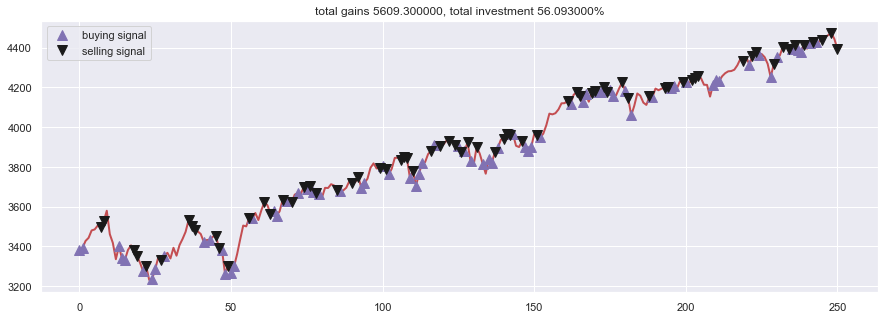

In [8]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [9]:
import pickle
with open('6evolution-strategy-agent.pkl', 'wb') as fopen:
    pickle.dump(agent, fopen)

# with open('my-agent.pkl', 'rb') as fopen:
#     agent = pickle.load(fopen)
